<h1><center>Collectors Co-working Networks</center></h1>
<h2><center>University of Brasília Herbarium (UB) dataset</center></h2>

<h4><center>Author: Pedro Correia de Siracusa</center></h4>
<h4><center>Date: Jun 5, 2017</center></h4>

---

<h3>Table of Contents</h3>

<ul>
    <li><a href="#1">Perspective 1. Which collectors have recorded species together?</a>
        <ul>
            <li><a href="#1.1">1.1 Building the network</a></li>
            <li><a href="#1.2">1.2 Subsetting the network G for visualization</a></li>
        </ul>     
    </li>
    
    <li><a href="#2">Perspective 2. Do collectors do fieldwork with others of similar profiles?</a>
        <ul>
            <li><a href="#2.1">2.1 The Brazilian Flora 2020 dataset</a></li>
            <li><a href="#2.2">2.2 Assigning profiles to nodes</a></li>
        </ul>  
    </li>
    
    <li><a href="#3">3. Conclusions and final considerations</a>
    </li>
    
</ul>        

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib as mpl
import seaborn as sns
import mpld3

from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,8)

In [2]:
colsList = ['scientificName', 'taxonRank', 'family', 
            'stateProvince', 'locality', 'municipality', 
            'recordedBy', 'identifiedBy',
            'eventDate']

In [3]:
ub_dset = pd.read_csv('./0077202-160910150852091/occurrence.txt', sep='\t', 
                 warn_bad_lines=False, 
                 error_bad_lines=False, 
                 usecols=colsList)

In [4]:
ub_dset = ub_dset[ub_dset['recordedBy'].notnull()]
ub_dset.describe()

,recordedBy,eventDate,stateProvince,municipality,locality,identifiedBy,scientificName,family,taxonRank
count,185806,181639,174288,135550,162465,148334,185805,183380,185805
unique,11310,18499,345,2757,57715,3655,20255,506,8
top,"Irwin, HS",2003-07-07T02:00Z,Distrito Federal,Brasília,"Lago Paranoá, Filtrado de 2 litros de água col...",Incógnito,Plantae,Fabaceae,SPECIES
freq,13277,390,51740,36424,2384,10644,2081,19227,140561


In [5]:
ub_dset.head()

,recordedBy,eventDate,stateProvince,municipality,locality,identifiedBy,scientificName,family,taxonRank
0,"Anderson, WR; Arroyo, MTK; Hill, SR; Santos, R...",1973-03-11T01:00Z,Goiás,NaN,8 km by road W of Monte Alegre.,"Delprete, PG",Sabicea brasiliensis Wernham,Rubiaceae,SPECIES
1,"Irwin, HS; Souza, R; Santos, RR",1965-12-03T01:00Z,Goiás,NaN,Serra de Pirineus. 20 km S. of Corumbá de Goiás.,"Delprete, PG",Sabicea brasiliensis Wernham,Rubiaceae,SPECIES
2,"Heringer, EP; Eiten, G",1974-12-20T01:00Z,Goiás,Caldas Novas,"At headwaters of creek, Rio Quente, near hotel...","Delprete, PG",Sabicea brasiliensis Wernham,Rubiaceae,SPECIES
3,"Anderson, WR; Hill, SR; Santos, RR; Souza, R",1973-05-11T01:00Z,Goiás,NaN,Serra Dourada. 16 km S of Goiás Velho.,"Delprete, PG",Sabicea brasiliensis Wernham,Rubiaceae,SPECIES
4,"Harley, RM; Giulietti, AML",1968-12-26T01:00Z,Goiás,Pirenópolis,NaN,"Delprete, PG",Rudgea viburnoides (Cham.) Benth.,Rubiaceae,SPECIES


In [6]:
d = ub_dset.set_index('recordedBy')

**Note:** Although the collectors' names follow the authorship name convention of the scientific community (Lastname, F. S.), there are still some inconsistencies on the dataset. For example, there are cases in which names referring to the same author were written slightly differently for different records. The names 'Irwin, H.S.' and 'Irwin, HS' refer to the same person, although in some records a period was appended to the author's names initials.

In [7]:
print("Number of records for Irwin, HS : {}\n\
Number of records for Irwin, H.S. : {}"\
          .format(d.loc['Irwin, H.S.'].size, d.loc['Irwin, HS'].size))

Number of records for Irwin, HS : 160
Number of records for Irwin, H.S. : 106216


---

# Perspective 1. Which collectors have recorded species together?
<a name="1"></a>

In order to tackle this question I will build a **collectors co-working network**, wherein two collectors are linked together if they have been both responsible for a particular record. Edges between two collectors are weighted according to the number of records that are shared by them. This is analogous to scientific co-authorship networks, where authors are linked if they have authored scientific papers together.

I will use the methods below to define the nodes and edges which will compose the network.

In [8]:
def collectorsFromString( colStr, splitOn=';' ):
    ''' Extracts names from a string separated by the splitOn argument '''
    collsList = [ col.strip() for col in colStr.split(splitOn) ]
    return [ coll for coll in collsList if coll!='' ]

def edgesFromClick(elements): 
    ''' Returns all the edges that make the elements list a click ''' 
    ls=[]
    elements = list(set(elements))
    for i,s in enumerate(elements):
        for t in elements[i+1:]:
            ls.append((s,t))
    return ls

In [9]:
from collections import Counter
edges = Counter([  edge for r in ub_dset['recordedBy'] for edge in edgesFromClick(collectorsFromString(r)) ])

## 1.1 Building the network $G$
<a name="1.1"></a>

In [10]:
G = nx.Graph(name='Collectors Network')
G.add_weighted_edges_from([ (e1,e2, edges[(e1,e2)]) for e1, e2 in edges ])

Who are the top-5 hubs on the network?

In [11]:
l = list(G.degree().items())
collectors_nrecords = pd.DataFrame( data=[ e[1] for e in l ], index=[ e[0] for e in l ], columns=['Num of Collaborators'] )
collectors_nrecords.sort_values(by='Num of Collaborators', ascending=False).head()

,Num of Collaborators
et al.,784
"Proença, CEB",246
"Ratter, JA",137
"Munhoz, CBR",128
"Faria, JEQ",127


From the table above we see that *et al.* is the highest degree collector node. This node must be removed from the network. Although we could perform this kind of filtering after building the network, I'll rewrite my `collectorsFromString()` method in order to include a new parameter `filters` through which we can specify the names that should be ignored. 

In [12]:
def collectorsFromString( colStr, splitOn=';',filters=[ 'et al.'] ):
    collsList = [ col.strip() for col in colStr.split(splitOn) ]
    return [ coll for coll in collsList if coll!='' and coll not in filters ]

Let's rebuild $G$ and check the top-10 hubs now.

In [13]:
G = nx.Graph(name='Collectors Network')

edges = Counter([  edge for r in ub_dset['recordedBy'] for edge in edgesFromClick(collectorsFromString(r)) ])
G.add_weighted_edges_from([ (e1,e2, edges[(e1,e2)]) for e1, e2 in edges ])
nx.set_node_attributes(G, 'size', G.degree()) # keep initial degree info

In [14]:
l = list(G.degree().items())
collectors_ncollab = pd.DataFrame( data=[ e[1] for e in l ], index=[ e[0] for e in l ], columns=['Num of Collaborators'] )
collectors_ncollab.sort_values(by='Num of Collaborators', ascending=False).head(10)

,Num of Collaborators
"Proença, CEB",245
"Ratter, JA",136
"Faria, JEQ",127
"Munhoz, CBR",127
"Silva, MA",108
"Carvalho, AM",107
"Mendonça, RC",97
"Souza, VC",96
"Oliveira, RC",96
"Walter, BMT",93


Some info on the collectors network

In [15]:
print(nx.info(G))

Name: Collectors Network
Type: Graph
Number of nodes: 4975
Number of edges: 12755
Average degree:   5.1276


Let's check the degree distribution of $G$.

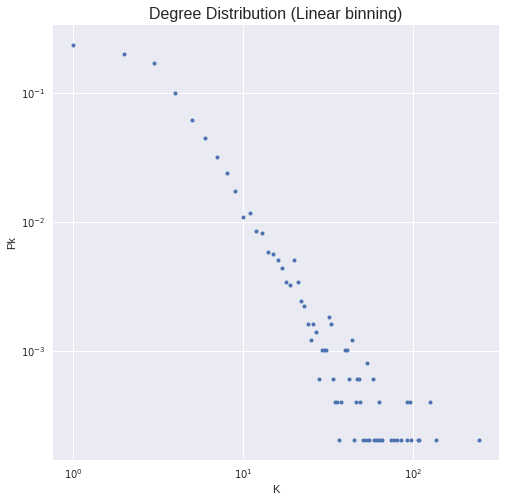

In [16]:
# linear binning
num_of_nodes = G.number_of_nodes()
y = [ i/num_of_nodes for i in nx.degree_histogram(G) ]

plt.loglog(y, marker='o', ls='', ms=4)
plt.ylabel('Pk')
plt.xlabel('K')
plt.title('Degree Distribution (Linear binning)', fontsize=16)

The figure above suggests that the collectors co-working network is **scale-free**, which means that few nodes are very popular (hubs) and many nodes have fewer connections. This topology is indicated by a power law relationship in the degree distribution plot.

As $G$ is fairly big, I will not plot it whole using matplotlib. Instead I will work with a subset of higher-degree nodes and their respective one-step neighbors. Nevertheless I will export the whole network for external visualization with *Gephi* at the end of the notebook. If you wish the graph is available for download [here](graphs/graph_n3.gexf).

## 1.2 Subsetting the network $G$ for visualization
<a name="1.2"></a>

I will subset $G$ by filtering out nodes with lower degree than specified by the parameter `hub_thresh`. All of the remaining nodes' one-step neighbors will also be kept. The resulting graph will be referred to as $G_{sub}$.

In [17]:
hub_thresh=50

In [18]:
nx.set_node_attributes(G, 'size', G.degree()) # keep initial degree info as size attribute

# select nodes with k>=hub_thresh
G_sub = G.subgraph( [ n for n in G.degree() if G.degree(n) >= hub_thresh ] )

# add 1-step neighbors of the selected nodes
edges_1 = [ (n, n_1) for n in G_sub.nodes() for n_1 in G[n] ] 
G_sub.add_edges_from(edges_1)

# keep nodes and edges attributes
nx.set_node_attributes(G_sub, 'size', dict([ (n, G.node[n]['size']) for n in G_sub.nodes() ]) )
nx.set_edge_attributes(G_sub, 'weight', dict([ ((u,v),G[u][v]['weight']) for u,v in G_sub.edges() ]) )

I want to quickly detect communities withing $G_{sub}$ based on the filtered nodes. For that I will use the [*Louvain algorithm*](http://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008/meta), which is designed to partition the network by keeping its modularity maximized. The group to which a node is assigned to is stored as a new attribute.

In [19]:
from community import best_partition

parts = best_partition(G_sub) #louvain algorithm

for n in G_sub:
    G_sub.node[n]['group'] = parts[n]

Now let's visualize $G_{sub}$. The *Fruchterman-Reingold* algorithm will be used to define the nodes drawing layout.

In [20]:
pos = nx.spring_layout(G_sub)

In [21]:
nodes = [ n for n in G_sub.nodes() ]
edges = [ e for e in G_sub.edges() ]

fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Collectors co-working network', fontsize=18)
fig.axes[0].patch.set_alpha(0)

# draw hubs
nodes_hubs = [ n for n in nodes if G_sub.node[n]['size'] >= hub_thresh ]
draw = nx.draw_networkx_nodes(G_sub, pos=pos, nodelist=nodes_hubs,
                       node_size=[ (G_sub.node[n]['size'])**1.6 for n in nodes_hubs ],
                       node_color=[ G_sub.node[n]['group'] for n in nodes_hubs ],
                       cmap=plt.get_cmap('jet'),
                       alpha=0.9)

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ n for n in nodes_hubs ]))


# draw neighbors
nodes_neighs = [ n for n in nodes if G_sub.node[n]['size'] < hub_thresh ]
draw = nx.draw_networkx_nodes(G_sub, pos=pos, nodelist=nodes_neighs,
                       node_size=[ (G_sub.node[n]['size'])**1.6 for n in nodes_neighs ],
                       node_color=[ G_sub.node[n]['group'] for n in nodes_neighs ],
                       cmap=plt.get_cmap('jet'),
                       alpha=0.5)

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ n for n in nodes_neighs ]))


# draw edges
spline = lambda x: 0.005*x + 0.05
draw = nx.draw_networkx_edges(G_sub, pos=pos, edgelist=edges,
                       width=[ spline(G_sub[u][v]['weight']) for u,v in edges ],
                       alpha=0.7)

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ G_sub[u][v]['weight'] for u,v in edges ]))


mpld3.display()

In the network above:

* **Node size** refers to a collector's degree, which is the number of other collectors he/she has worked with;
* **Node color** refers to the group he/she belongs to (inferred from node's connectivity);
* **Edge thickness** refers to its weight, which represents the number of records two collectors have co-authored.

By inspecting the network closely (you can navigate through the plot) hubs apparently keep stronger links with lower-degree nodes, which in turn usually do not keep links as strong with any other collector. It is worth noting that although novice collectors invariably have lower degrees, **a lower-degree collector is not necessarily less experienced in fieldwork than a higher degree-one**. Having lower degrees simply means they are less collaborative (**singleton collectors**). In order to distinguish novice from experienced collectors we would have to consider the number of records they have authored (either alone or colaboratively). This aspect was still not addressed in this analysis. In addition, we can also note that hubs usually do not keep strong links with other hubs. Most patches (considering weight) between them are intermediated by lower-degree nodes. 

From this network we can also try to identify the degree to which two collectors are associated. If a low-degree node $n_1$ is linked by a strong edge with another node $n_2$ then $n_1$ is **strongly associated** with $n_1$, although the inverse is not necessarily true. If both $n_1$ and $n_2$ both have low degrees and are strongly linked then they are **mutually strongly associated** (*Note that here, for simplicity, I am considering that a singleton experienced collector's association with another one is not affected by the number of records he/she has obtained alone! Singleton records that would naturally contribute to "disassociate" two collectors is disregarded here, as only colaborative records are considered*). With thas in mind, we might ask whether collectors that are strongly associated have similar recording profiles. I will investigate this in the next topic.

---

# Perspective 2. Do collectors do fieldwork with others of similar profiles?
<a name="2"></a>

In the previous section I have built a collectors co-working network, in which collectors were classified in groups based on whom they have done field recordings with. Now I want to investigate if those groups are formed by collectors with similar recording profiles. Possible recording profiles might be, for example, specialist recorders (which are interested on particular taxonomic or functional groups) vs. generalists recorders (which are interested on sampling as much species diversity as they can). Basically I will look at how frequent are the following cases in the network:

* Collectors have similar profiles (share interest on similar groups) and have **not** worked together;
* Collectors have distinct profiles and have worked together.

Here I will profile each collector based on their interest in species that have either **herbaceous** or **tree** life forms. Although this is an oversimplification of the true range of different profiles collectors might have, three tendencies should be observed. Collectors might be either:

1. **Herbaceous specialists** (have recorded a higher proportion of herbaceous species); 
2. **Tree specialists** (have recorded a higher proportion of tree species); 
3. **Generalists** (have recorded a similar proportion of herbaceous and tree species).

## 2.1 The Brazilian Flora 2020 dataset
<a name="2.1"></a>

In order to include ecological information about species, I will use the [Brazilian Flora 2020 dataset](http://floradobrasil.jbrj.gov.br/reflora/listaBrasil/PrincipalUC/PrincipalUC.do;jsessionid=DED0FACA93311D633FBA67A269FD3D0D#CondicaoTaxonCP), a project that is part of the [JBRJ Reflora Programme](http://reflora.jbrj.gov.br/reflora/PrincipalUC/PrincipalUC.do?lingua=en) which aims to gather information about the distribution and ecology of the Brazilian flora. I am particularly interested in the `lifeForm` and `habitat` columns.

In [22]:
taxon = pd.read_table('./datasets/dwca-lista_especies_flora_brasil-v393.113/taxon.txt', sep='\t', 
                     usecols=['id', 'scientificName', 'taxonRank'], index_col='id')

prof = pd.read_table('./datasets/dwca-lista_especies_flora_brasil-v393.113/speciesprofile.txt', sep='\t', 
                     index_col='id')

flora = taxon.join(prof)

In [23]:
flora[ flora['lifeForm'].notnull() ].head()

,scientificName,taxonRank,lifeForm,habitat
id,,,,
264,Adiscanthus fusciflorus Ducke,ESPECIE,Árvore,Terrícola
271,Almeidea coerulea (Nees & Mart.) A.St.-Hil.,ESPECIE,Árvore,Terrícola
274,Almeidea lilacina A.St.-Hil.,ESPECIE,Árvore,Terrícola
275,Almeidea limae I.M.Silva,ESPECIE,Árvore,Terrícola
277,Almeidea rubra A.St.-Hil.,ESPECIE,Árvore,Terrícola


* What are the life forms and habitats in which plants are classified?

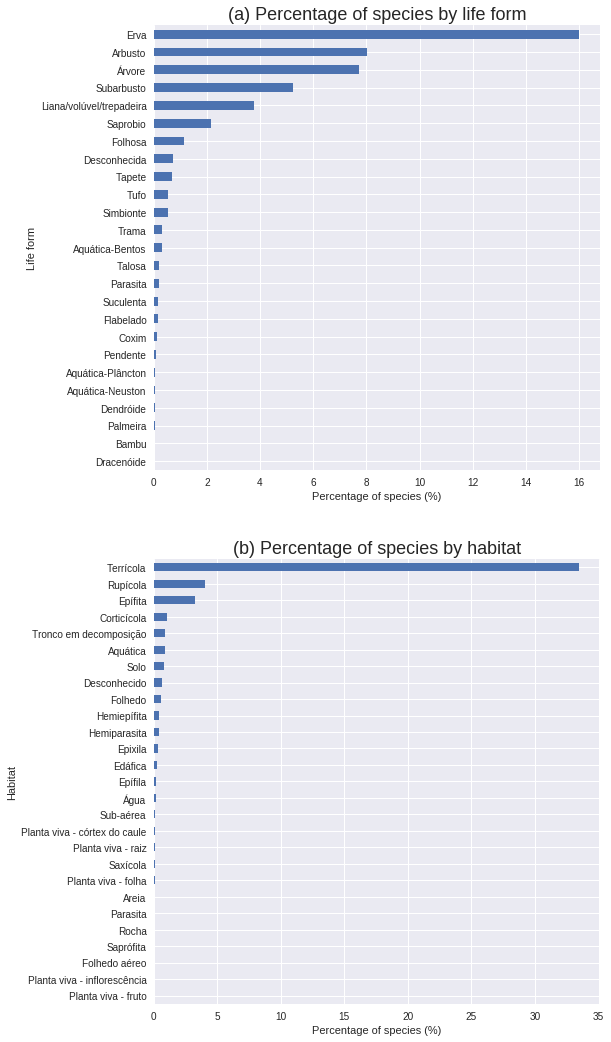

In [24]:
flora_numofspp = len(flora.index.unique())

plt.figure(1, figsize=(8,18))
plt.title('supertitle')

plt.subplot(211)
flora['lifeForm'].value_counts(ascending=True).apply(lambda x: x/flora_numofspp*100).plot(kind='barh')
plt.title('(a) Percentage of species by life form', fontsize=18)
plt.xlabel('Percentage of species (%)')
plt.ylabel('Life form')

plt.subplot(212)
flora['habitat'].value_counts(ascending=True).apply(lambda x: x/flora_numofspp*100).plot(kind='barh', ax=plt.gca())
plt.title('(b) Percentage of species by habitat', fontsize=18)
plt.xlabel('Percentage of species (%)')
plt.ylabel('Habitat')

By quickly inspecting the bar plot above we realize that the percentages of the species classified by habitat and lifeform do not sum up to 100%. Habitat and life form information is missing for many species on this dataset. Another issue with this dataset is that the index is not unique, which means that some species may have different life forms or habitats, and are registered as multiple entries:

In [25]:
flora.ix[1479]

,scientificName,taxonRank,lifeForm,habitat
id,,,,
1479,Coleocephalocereus goebelianus (Vaupel) Buining,ESPECIE,Arbusto,Terrícola
1479,Coleocephalocereus goebelianus (Vaupel) Buining,ESPECIE,Arbusto,Rupícola
1479,Coleocephalocereus goebelianus (Vaupel) Buining,ESPECIE,Árvore,Terrícola
1479,Coleocephalocereus goebelianus (Vaupel) Buining,ESPECIE,Árvore,Rupícola


The problem is that if we were to join this table with the occurrences dataset we would have to either ignore the fact that some plants may have different lifeforms/habitat or copy occurrences in which this happens. To overcome this I will transform these columns in order to make the flora dataset's index unique before joining the tables. If a species has multiple life forms or habitats these values will be concatenated and separated by a "/".

In [26]:
dup_indexes = flora.index.get_duplicates()
dup_groups = flora.ix[dup_indexes].groupby(level=0)

joined_lifeform = dup_groups.apply( lambda g: '/'.join(g['lifeForm'].unique()) )
joined_habitat = dup_groups.apply( lambda g: '/'.join(g['habitat'].unique()) )

flora_uq = flora.copy()

flora_uq.ix[dup_indexes,'habitat'] = joined_habitat
flora_uq.ix[dup_indexes, 'lifeForm'] = joined_lifeform
flora_uq.drop_duplicates(keep='first', inplace=True)

assert(flora_uq.index.is_unique)

And now we can finally merge the occurrences dataset with the flora dataset. This will introduce two new columns on the `ub_dset` which contain, the life form and habitat of the recorded species. The resulting dataset will be referenced by the variable `occ_dset`, and will be used from now on.

In [27]:
occ_dset = ub_dset.merge(flora_uq.drop(['taxonRank'],axis=1), how='left', on='scientificName')
assert(occ_dset.shape[0]==ub_dset.shape[0])

Now that we have merged our original occurrences dataset with the flora dataset, let's get back to the issue regarding the null values in the columns `lifeForm` and `habitat`. How many occurrences refer to species that do have information about their **life form** and **habitat**?

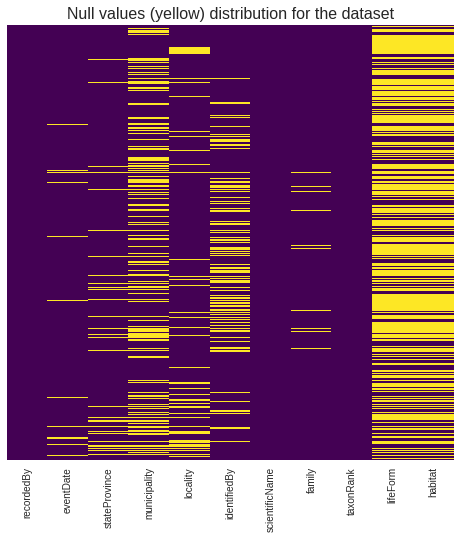

In [28]:
sns.heatmap(data=occ_dset.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title("Null values (yellow) distribution for the dataset", fontsize=16)

The figure above shows the distribution of null values (represented as yellow bars) in the dataset. It is worth noting that for most records there are no information about the species' life form and habitat. We could further try to perform some data imputation based on species taxonomic proximity with others for which such information is available, but this task is outside the scope of this notebook. A possible limitation due to the missing data in the flora dataset would be that many trees or herbs species were simply not be considered.

## 2.2 Assigning profiles to nodes
<a name="2.2"></a>

Now let's filter the dataset and keep only the records of species that are either tree or herb. The filtered dataset is assigned to the `herbs_trees` variable.

In [29]:
herbs = occ_dset[ occ_dset['lifeForm'].str.contains('Erva', na=False) ]
trees = occ_dset[ occ_dset['lifeForm'].str.contains('Árvore', na=False) ]
herbs_trees = herbs.append(trees)

I will use $P$ as a simple metric for classifying recorders in either herbaceous-specialists, tree-specialists or generalists, such that:

$$ P = \frac{n_{herb}}{n_{herb \cup tree}} $$

where $n_{herb}$ and $n_{herb \cup tree}$ are respectively the number of herbaceous species a collector has recorded and his/her total number of records of either herbs or trees.

In [30]:
def countRecordsByAllCollectors(df):
    cts = Counter([ c for r in df['recordedBy'] for c in collectorsFromString(r) ])
    return cts

n_herb = countRecordsByAllCollectors(herbs)
n_hut = countRecordsByAllCollectors(herbs_trees)

Now, in order to use the same layout as the first network plotted on this notebook, I will intersect the `herbs_trees` nodes with those from the subgraph $G_{sub}$. In other words, only nodes from `G_sub` that have collected herbs or trees will be shown.

In [31]:
intersection = set(G_sub.nodes()).intersection(set(n_hut.keys()))
nodes_to_remove = set(G_sub.nodes()).difference(intersection)

for n in intersection:
    G_sub.node[n]['P'] = n_herb[n]/n_hut[n]
    
G_sub.remove_nodes_from(nodes_to_remove)

In [32]:
nodes = [ n for n in G_sub.nodes() ]
edges = [ e for e in G_sub.edges() ]

fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Collectors co-working network', fontsize=18)
fig.axes[0].patch.set_alpha(0)

# draw hubs
nodes_hubs = [ n for n in nodes if G_sub.node[n]['size'] >= hub_thresh ]
draw = nx.draw_networkx_nodes(G_sub, pos=pos, nodelist=nodes_hubs,
                       node_size=[ (G_sub.node[n]['size'])**1.6 for n in nodes_hubs ],
                       node_color=[ G_sub.node[n]['P'] for n in nodes_hubs ],
                       cmap=plt.get_cmap('spring'),
                       alpha=0.9)

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, 
            labels=[ "{}: {:.3}%".format(n, G_sub.node[n]['P']*100) for n in nodes_hubs ]))


# draw neighbors
nodes_neighs = [ n for n in nodes if G_sub.node[n]['size'] < hub_thresh ]
draw = nx.draw_networkx_nodes(G_sub, pos=pos, nodelist=nodes_neighs,
                       node_size=[ (G_sub.node[n]['size'])**1.6 for n in nodes_neighs ],
                       node_color=[ G_sub.node[n]['P'] for n in nodes_neighs ],
                       cmap=plt.get_cmap('spring'),
                       alpha=0.5)

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, 
             labels=[ "{}: {:.3}%".format(n, G_sub.node[n]['P']*100) for n in nodes_neighs ]))


# draw edges
spline = lambda x: 0.005*x + 0.05
draw = nx.draw_networkx_edges(G_sub, pos=pos, edgelist=edges,
                       width=[ spline(G_sub[u][v]['weight']) for u,v in edges ],
                       alpha=0.7)

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ G_sub[u][v]['weight'] for u,v in edges ]))


mpld3.display()

The graph above shows the collectors network for those who have either collected herbaceous or tree species. The layout used for drawing nodes is the same as in the previous draw, which means that all nodes are in the same position. However the color of nodes here represent their position in the trees-herbs interest gradient (given by the $P$ metric). Yellow nodes are those who have mostly recorded herbs, whereas purple nodes have mostly recorded trees. Generalist collectors are colored with an intermediary tone (redish?). You can verify the value of $P$ for each node by hovering the cursor on top of them.

By looking at the hubs, we verify that each individual collector show different tendencies in terms of their profiles and collaborations. I will point out the following collectors, although more fruitful insights might be obtained by inspecting this graph with more adequate tools such as *Gephi*:

* *Munhoz, CBR* is a herbaceous specialist who has stronger links with fewer collectors, most of them herbaceous specialists (and a few generalists);
* *Proença, CEB* is a generalist collector who has links with many collectors, although few are considerably strong.
* *Faria, JEQ* apparently has a preference for trees although he/she has strong links with many collectors, including with herbaceous specialists (*Carvalho-Silva, M*). This is a more collaborative profile.
* Although they are both herbaceous specialists, *Munhoz, CBR* and *Oliveira, RC* apparently have not done much fieldwork together (they have been assigned to different groups as pointed by the first draw).

Another interesting aspect is that one of the hubs, *Shevock, JR* has been filtered out, and one might naturally conclude that he hasn't recorded any herbs or trees. However, this is not necessarily the case. It might be the case that the species *Shevock* has collected simply were not classified in the flora dataset. In fact, it turns out that *Shevock* is apparently a foreign collector (all his/her records are not in Brazil), which makes it natural that the species he/she has recorded are not in the flora dataset. This may also be the reason for the fact that although he/she is a hub, it is not linked to the network's giant component.

In [33]:
# print 5 distinct localities where Shevock has collected
for i in occ_dset[occ_dset['recordedBy'].str.contains('Shevock, JR')]['locality'].unique()[:5]:
    print(i+'\n--')

Russian wilderness, Klamath National Forest. Siskiyou county, CA. Salmon Mountains. Along stream just below lake outlet off of trail at Sugar Lake from trailhead off forest road 41N14. R9W, T40N, section 19. NAD 83
--
Russian wilderness, Klamth National Forest. Siskiyou county, CA. Salmon Mountains. Along stream just below lake outlet off of trail at Sugar Lake from trailhead off forest road 41N14. R9W, T40N, section 19. NAD 83
--
Marble MTN Wilderness, Klamth National Forest, Siskiyou County, CA. Along Marble Valley Trail above trail junction to Red Rock Valley, about 1mile above Lovers Camp at end of forest road 43N45. R11W, T43N, section 18
--
Scott River Drainage, Klamath National Forest. Siskiyou County, CA. Marble Mountains just north of the Marble Mountains Wlderness boundary. Lovers Camp at end of forest road 43N45. R11W, T43N, section 8
--
Marble MTN Wilderness, Klamth National Forest, Siskiyou County, CA. Marble Valley, just above trail junction with the Pacific Crest Trail, 

# 3. Conclusions and final considerations
<a name="3"></a>

* Studying collectors co-working networks could be helpful for gaining insights on how adequate his/her data is for our modeling purposes: Is his/her sampling likely to be biased towards a particular group (data from specialists)? 

* Collectors' may be classified in profiles depending on their groups of interest and on how they usually records species. Are they singleton recorders? Do they co-work with big teams (containing specialists in different groups or generalists) or are involved in big projects (like species sensus)? Are they generalist or specialist collectors? In which groups?

* In this kind of network simply using node degree as a parameter to define its size can be misleading, as singleton collectors will be represented as small nodes (leading to an idea of irrelevance) even though they might actually be experienced and productive ones;

* Building **ego networks** centered on collectors of interest could be a more visual way to gain insights on their profiles.


In [34]:
try: os.makedirs('./graphs')
except FileExistsError: pass

nx.write_gexf(G, path='./graphs/graph_n3.gexf')

In [35]:
%%HTML 
<style>
g.mpld3-xaxis{display:none;}
g.mpld3-yaxis{display:none;}
</style>